In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB





In [3]:
# Basic preprocessing
def preprocess(df):
    df_new = df.copy()
    
    # Discard identifiers, style information, timestamps
    df_new = df_new[df_new.columns.difference(['image', 'style', 'reviewTime', 
                                               'reviewerID', 'asin', 'reviewerName', 'unixReviewTime'])]

    # Turn category into binary features
    for cat in df_new.category.unique():
        df_new[cat] = df_new['category'] == cat

    # Drop category column
    df_new.drop(columns=['category'], inplace=True)

    # NaN vote is 0 users found helpful
    df_new.vote.fillna(0, inplace=True)
    
    # Turn vote into binary feature
    df_new.vote = df_new.vote > 0
    # df_new.vote.clip(0, 10)
    # df_new.vote = df_new.vote / 10

    # NaN summary is empty summary
    df_new.summary.fillna('', inplace=True)

    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new

In [4]:
# Remove 'overall' column and add cutoff column applying cutoff
def apply_cutoff(df, cutoff):
    df_new = df.copy()
    
    # Apply cutoff
    cut = df['overall'] > cutoff
    df_new['cutoff'] = cut

    # Drop overall and category
    df_new.drop(columns=['overall'], inplace=True)
    
    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new

In [5]:
def apply_tfidf(df, review_vectorizer, summary_vectorizer):
    review_matrix = pd.DataFrame(data=review_vectorizer.transform(df.reviewText).toarray(), columns='R_' + review_vectorizer.get_feature_names_out())
    summary_matrix = pd.DataFrame(data=summary_vectorizer.transform(df.summary).toarray(), columns='S_' + summary_vectorizer.get_feature_names_out())
    df_new = pd.concat([df, review_matrix, summary_matrix], axis=1)
    df_new.drop(columns=['summary', 'reviewText'], inplace=True)
    return df_new

In [6]:
training_df = pd.read_csv('../data/Training.csv')
test_df = pd.read_csv('../data/Test.csv')

# Processing the data - I

In [7]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 1)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [8]:
X

,verified,vote,automotive,CDs,grocery,cell_phones,sports,toys,R_00,R_000,...,S_zest,S_zest far,S_zest far inferior,S_zimmer,S_zipper,S_zippers,S_zoom,S_zz,S_zz greatest,S_zz greatest hits
0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
relcols

Index(['verified', 'vote', 'R_00', 'R_08', 'R_10 bucks', 'R_12', 'R_15',
       'R_1970', 'R_1970s', 'R_1973',
       ...
       'S_wtf', 'S_year old', 'S_young', 'S_yuck', 'S_yucky', 'S_yuk', 'S_yum',
       'S_yummy', 'S_zero', 'S_zero stars'],
      dtype='object', length=4272)

In [10]:
# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

in gaussian mechanism MechanizedDecisionTree


[Text(0.8415096507352942, 0.9545454545454546, 'x[21548] <= 0.485\ngini = 0.323\nsamples = 23351\nvalue = [4724, 18627]'),
 Text(0.7271369485294118, 0.8636363636363636, 'x[21557] <= 0.343\ngini = 0.291\nsamples = 22631\nvalue = [4008, 18623]'),
 Text(0.5645680147058824, 0.7727272727272727, 'x[1] <= 0.711\ngini = 0.331\nsamples = 19044\nvalue = [3991, 15053]'),
 Text(0.3984375, 0.6818181818181818, 'x[16080] <= 0.434\ngini = 0.297\nsamples = 14361\nvalue = [2601, 11760]'),
 Text(0.3115808823529412, 0.5909090909090909, 'x[22580] <= 0.35\ngini = 0.293\nsamples = 14305\nvalue = [2552, 11753]'),
 Text(0.2261029411764706, 0.5, 'x[21958] <= 0.427\ngini = 0.289\nsamples = 14227\nvalue = [2494, 11733]'),
 Text(0.17279411764705882, 0.4090909090909091, 'x[14759] <= 0.346\ngini = 0.287\nsamples = 14191\nvalue = [2463, 11728]'),
 Text(0.11029411764705882, 0.3181818181818182, 'x[15748] <= 0.399\ngini = 0.285\nsamples = 14153\nvalue = [2433, 11720]'),
 Text(0.058823529411764705, 0.22727272727272727, 'x

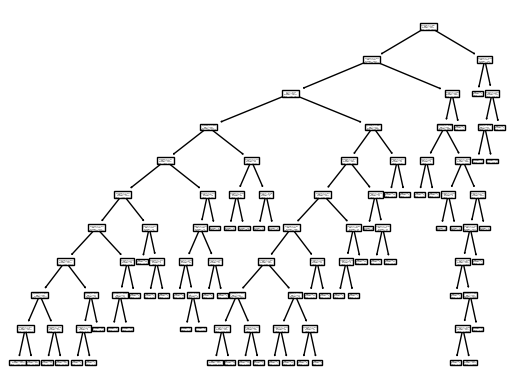

In [11]:
# Hyperparameter selection on one split
import sys
sys.path.append("..")
from mechanism.mechanized_models import Mechanism
from mechanism.mechanized_models import MechanizedGridSearchCV
from mechanism.mechanized_models import MechanizedDecisionTree
from sklearn import tree
        

X_train, X_val, y_train, y_val = splits[0]
estimator = MechanizedDecisionTree( max_depth=10)
estimator.choose_mechanism(Mechanism.GAUSSIAN)
X_train, X_val, y_train, y_val = splits[0]
estimator.fit(X_train, y_train)
# tree.plot_tree(estimator)

## Mechanized Decision Tree Classifier

In [11]:
# Hyperparameter selection on one split
import sys
sys.path.append("..")
from mechanism.mechanized_models import Mechanism
from mechanism.mechanized_models import MechanizedGridSearchCV
from mechanism.mechanized_models import MechanizedDecisionTree
from sklearn import tree
        

X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedDecisionTree()
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)

params_DT = {'criterion': ['entropy','gini'], 'max_depth': np.arange(40, 100, 30)}

gs_DT = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_DT, cv = 2, verbose=3, scoring='f1_macro')
gs_DT.choose_mechanism(Mechanism.GAUSSIAN)

gs_DT.fit(X_train, y_train)
gs_DT.best_params_

in gaussian mechanism GridSearchCV
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ...criterion=entropy, max_depth=40;, score=0.546 total time=13.8min


In [13]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = MechanizedDecisionTree(**gs_DT.best_params_)
    model.choose_mechanism(Mechanism.GAUSSIAN)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.652034293477263
  Accuracy: 0.8331620417951353
  ROC/AUC score: 0.6774487866691676
Split 1:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.6773739737592872
  Accuracy: 0.8518328194587187
  ROC/AUC score: 0.7010170853161368
Split 2:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.6585426735671747
  Accuracy: 0.8336759164097294
  ROC/AUC score: 0.645692143333858
Split 3:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.650236018214901
  Accuracy: 0.8377869133264817
  ROC/AUC score: 0.6422444306717308
Split 4:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.6573296564853711
  Accuracy: 0.8338187425047113
  ROC/AUC score: 0.6468705976694287
Average F1 score: 0.6591033231007993
Average accuracy: 0.8380552866989552
Average ROC/AUC score: 0.6626546087320644


Text(50.722222222222214, 0.5, 'True label')

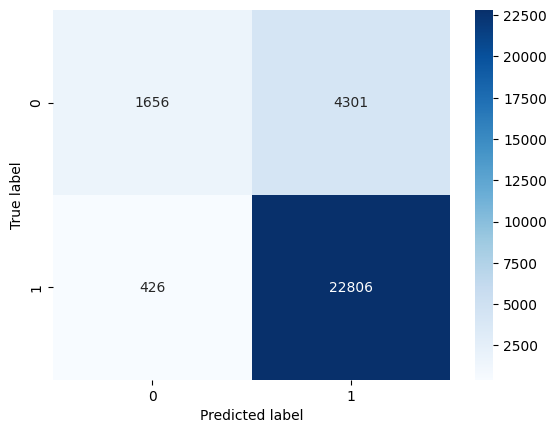

In [14]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

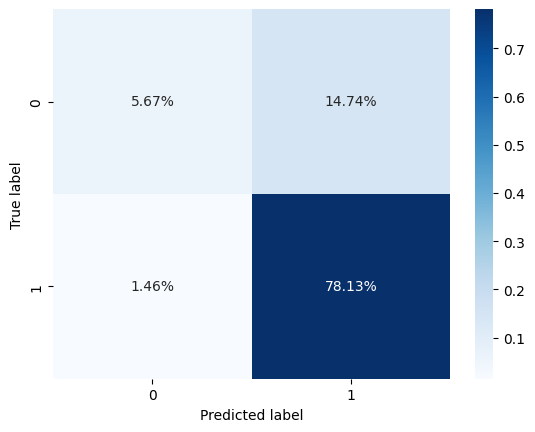

In [15]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [16]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = MechanizedDecisionTree(**gs_DT.best_params_)
model.choose_mechanism(Mechanism.GAUSSIAN)
model.fit(X_train, y_train)

in gaussian mechanism MechanizedDecisionTree


MechanizedDecisionTree(max_depth=40)

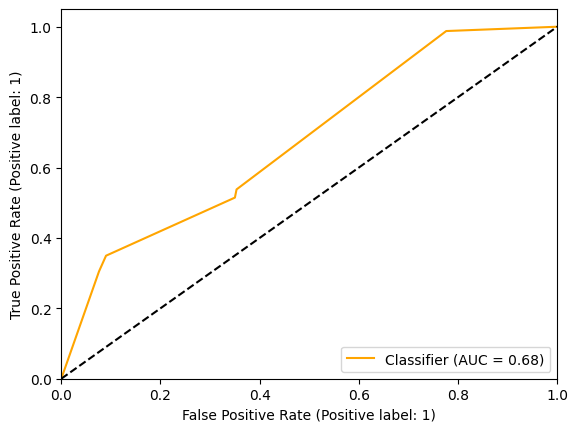

In [17]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [18]:
model1 = LogisticRegression(C=5.011872336272722, max_iter=1500)
model1.fit(X, y)

LogisticRegression(C=5.011872336272722, max_iter=1500)

In [19]:
# # Extra testing
# (X_train, X_val, y_train, y_val) = splits[np.argmax(f1_scores) % 5]
# f1_score(y_val, (model2.predict_proba(X_val) >= 0.7)[:, 1].astype(int), average='macro')

In [20]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [21]:
# Predict on test and save as .csv
# proc_test_df['predicted'] = model1.predict(proc_test_df)
proc_test_df['predicted'] = (model1.predict_proba(proc_test_df) >= 0.7)[:, 1].astype(int) # yields better F1 score!
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task11.csv', index=False)

# Processing data - II

In [22]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 2)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Mechanized Decision Tree Classifier

In [23]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedDecisionTree()
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)
params_DT = {'criterion': ['entropy','gini'], 'max_depth': np.arange(40, 100, 30)}
gs_DT = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_DT,  cv = 2, verbose=3, scoring='f1_macro')
gs_DT.choose_mechanism(Mechanism.GAUSSIAN)
gs_DT.fit(X_train, y_train)
gs_DT.best_params_

in gaussian mechanism GridSearchCV
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ...criterion=entropy, max_depth=40;, score=0.556 total time= 3.0min
[CV 2/2] END ...criterion=entropy, max_depth=40;, score=0.574 total time= 2.7min
[CV 1/2] END ...criterion=entropy, max_depth=70;, score=0.560 total time= 3.7min
[CV 2/2] END ...criterion=entropy, max_depth=70;, score=0.577 total time= 2.5min
[CV 1/2] END ......criterion=gini, max_depth=40;, score=0.560 total time= 2.2min
[CV 2/2] END ......criterion=gini, max_depth=40;, score=0.557 total time= 1.8min
[CV 1/2] END ......criterion=gini, max_depth=70;, score=0.570 total time= 2.3min
[CV 2/2] END ......criterion=gini, max_depth=70;, score=0.562 total time= 1.9min


{'criterion': 'entropy', 'max_depth': 70}

In [24]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = MechanizedDecisionTree(**gs_DT.best_params_)
    model.choose_mechanism(Mechanism.GAUSSIAN)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.647593828656345
  Accuracy: 0.6795135320315177
  ROC/AUC score: 0.7164068376138986
Split 1:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.6181810126395337
  Accuracy: 0.6229873244261733
  ROC/AUC score: 0.6513811084696689
Split 2:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.6363271499555192
  Accuracy: 0.6688934566632408
  ROC/AUC score: 0.7094643910806382
Split 3:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.601595113928475
  Accuracy: 0.6075710859883522
  ROC/AUC score: 0.6293377898884555
Split 4:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.6417429484597764
  Accuracy: 0.681685797498715
  ROC/AUC score: 0.6413017992327303
Average F1 score: 0.6290880107279297
Average accuracy: 0.6521302393215997
Average ROC/AUC score: 0.6695783852570782


Text(50.722222222222214, 0.5, 'True label')

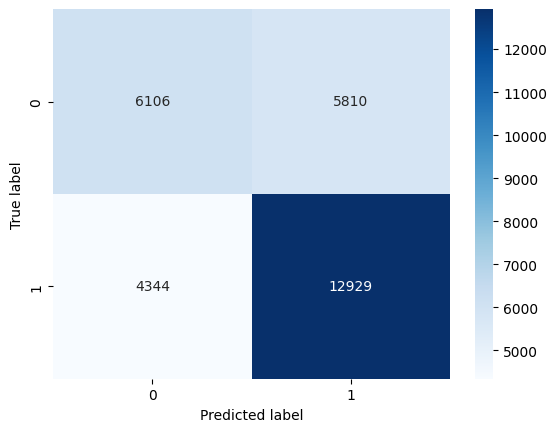

In [25]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

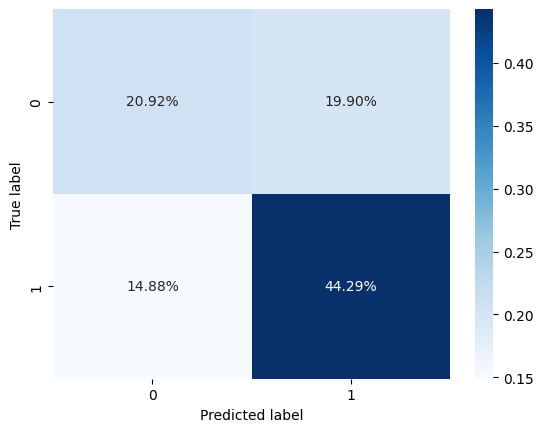

In [26]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [27]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = MechanizedDecisionTree(**gs_DT.best_params_)
model.choose_mechanism(Mechanism.GAUSSIAN)
model.fit(X_train, y_train)

in gaussian mechanism MechanizedDecisionTree


MechanizedDecisionTree(criterion='entropy', max_depth=70)

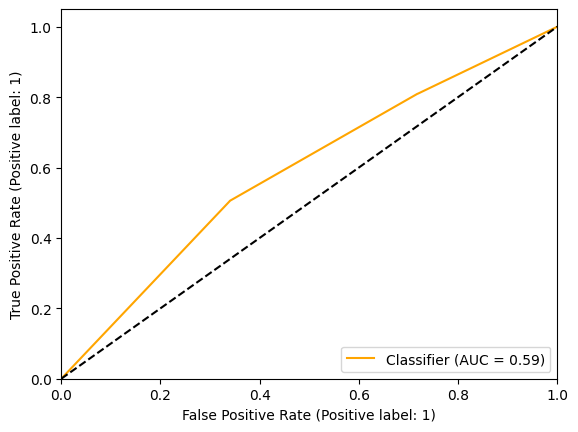

In [28]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [29]:
model2 = LogisticRegression(C=5.011872336272722, max_iter=1500)
model2.fit(X, y)

LogisticRegression(C=5.011872336272722, max_iter=1500)

In [30]:
# # Extra testing
# (X_train, X_val, y_train, y_val) = splits[np.argmax(f1_scores) % 5]
# f1_score(y_val, (model2.predict_proba(X_val) >= 0.54)[:, 1].astype(int), average='macro')

In [31]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [32]:
# Predict on test and save as .csv
proc_test_df['predicted'] = model2.predict(proc_test_df)
# proc_test_df['predicted'] = (model2.predict_proba(proc_test_df) >= 0.54)[:, 1].astype(int) # yields better F1 score!
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task12.csv', index=False)

# Processing the data - II

In [33]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 3)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Mechanized Decision Tree Classifier

In [ ]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedDecisionTree()
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)
params_DT = {'criterion': ['entropy','gini'], 'max_depth': np.arange(40, 100, 12)}
gs_DT = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_DT,  cv = 2, verbose=3, scoring='f1_macro')
gs_DT.choose_mechanism(Mechanism.GAUSSIAN)
gs_DT.fit(X_train, y_train)
gs_DT.best_params_

: 

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits[:1]):
    print(f"Split {i}:")
    # Train model
    model = MechanizedDecisionTree(**gs_DT.best_params_)
    model.choose_mechanism(Mechanism.GAUSSIAN)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.6617967442577983
  Accuracy: 0.6951010620075369
  ROC/AUC score: 0.6881013169632701
Average F1 score: 0.6617967442577983
Average accuracy: 0.6951010620075369
Average ROC/AUC score: 0.6881013169632701


Text(50.722222222222214, 0.5, 'True label')

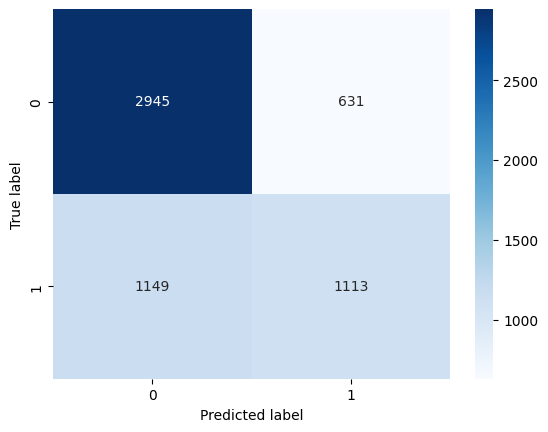

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

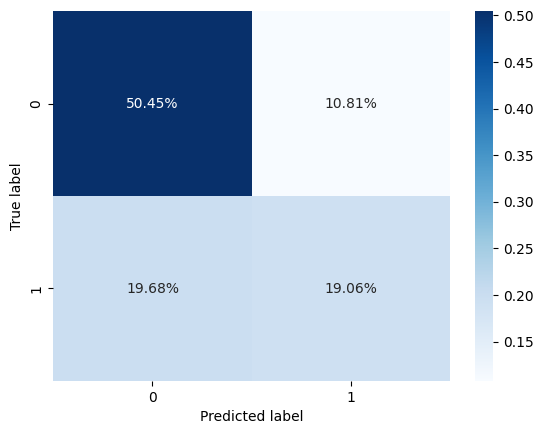

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = MechanizedDecisionTree(**gs_DT.best_params_)
model.choose_mechanism(Mechanism.GAUSSIAN)
model.fit(X_train, y_train)

in gaussian mechanism MechanizedDecisionTree


MechanizedDecisionTree(max_depth=40)

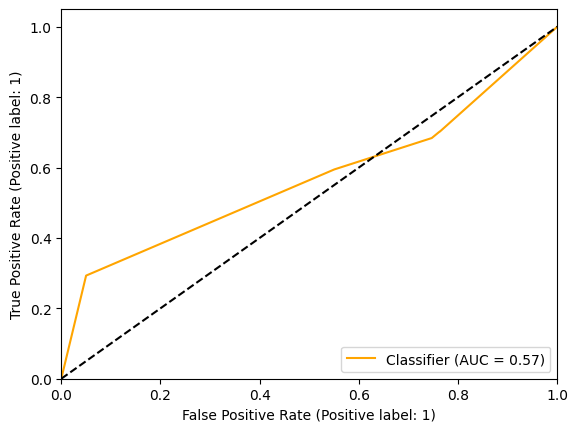

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [ ]:
# This model seems to perform better on the public test data.
model3 = LogisticRegression(C=5.011872336272722, max_iter=1500)
model3.fit(X, y)

LogisticRegression(C=5.011872336272722, max_iter=1500)

In [ ]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [ ]:
# Predict on test and save as .csv
proc_test_df['predicted'] = model3.predict(proc_test_df)
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task13.csv', index=False)

# Processing the data - IV

In [7]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 4)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Mechanized Decision Tree Classifier

In [8]:
# Hyperparameter selection on one split
import sys
sys.path.append("..")
from mechanism.mechanized_models import Mechanism
from mechanism.mechanized_models import MechanizedGridSearchCV
from mechanism.mechanized_models import MechanizedDecisionTree


# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedDecisionTree()
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)
params_DT = {'criterion': ['entropy','gini'], 'max_depth': np.arange(40, 100, 30)}
gs_DT = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_DT,  cv = 2, verbose=3, scoring='f1_macro')
gs_DT.choose_mechanism(Mechanism.GAUSSIAN)
gs_DT.fit(X_train, y_train)
gs_DT.best_params_

in gaussian mechanism GridSearchCV
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ...criterion=entropy, max_depth=40;, score=0.549 total time= 2.7min
[CV 2/2] END ...criterion=entropy, max_depth=40;, score=0.559 total time= 2.7min
[CV 1/2] END ...criterion=entropy, max_depth=70;, score=0.545 total time= 2.5min
[CV 2/2] END ...criterion=entropy, max_depth=70;, score=0.553 total time= 2.9min
[CV 1/2] END ......criterion=gini, max_depth=40;, score=0.568 total time= 2.5min
[CV 2/2] END ......criterion=gini, max_depth=40;, score=0.578 total time= 2.6min
[CV 1/2] END ......criterion=gini, max_depth=70;, score=0.567 total time= 5.2min
[CV 2/2] END ......criterion=gini, max_depth=70;, score=0.573 total time= 9.4min


{'criterion': 'gini', 'max_depth': 40}

In [9]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits[:1]):
    print(f"Split {i}:")
    # Train model
    model = MechanizedDecisionTree(**gs_DT.best_params_)
    model.choose_mechanism(Mechanism.GAUSSIAN)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.6143479984145858
  Accuracy: 0.8191161356628982
  ROC/AUC score: 0.5793996734052242
Average F1 score: 0.6143479984145858
Average accuracy: 0.8191161356628982
Average ROC/AUC score: 0.5793996734052242


Text(50.722222222222214, 0.5, 'True label')

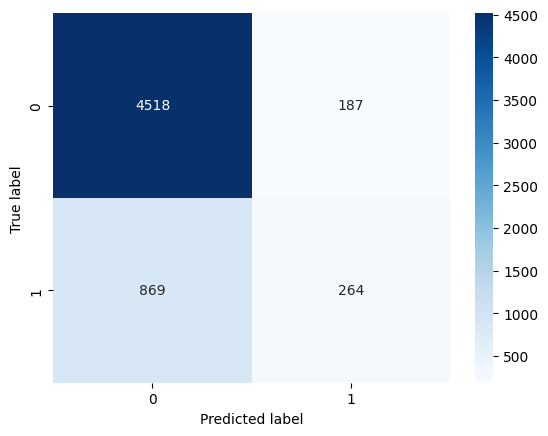

In [10]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

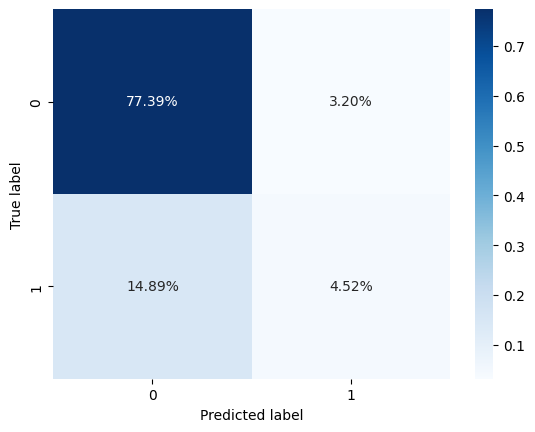

In [11]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [12]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = MechanizedDecisionTree(**gs_DT.best_params_)
model.choose_mechanism(Mechanism.GAUSSIAN)
model.fit(X_train, y_train)

in gaussian mechanism MechanizedDecisionTree


MechanizedDecisionTree(max_depth=40)

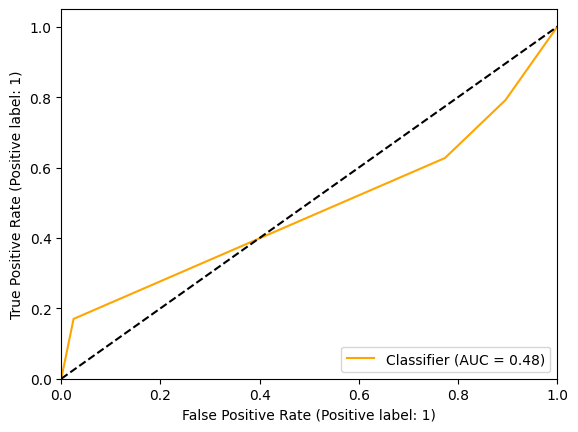

In [13]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [14]:
# This model seems to perform better on the public test data.
model4 = LogisticRegression(C=10.7977516232771, max_iter=1500)
model4.fit(X, y)

LogisticRegression(C=10.7977516232771, max_iter=1500)

In [15]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [16]:
# Predict on test and save as .csv
proc_test_df['predicted'] = model4.predict(proc_test_df)
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task14.csv', index=False)